In [1]:
import berrylib.util as util

util.setup_nb()

In [2]:
import matplotlib.pyplot as plt
import scipy.stats
import numpy as np
from scipy.special import logit

import berrylib.fast_inla as fast_inla

/Users/tbent/.mambaforge/envs/imprint/lib/python3.10/site-packages/jax/_src/lib/__init__.py:33: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


# Simulation

In [8]:
p0 = np.array(
    [0.05, 0.05, 0.1, 0.2]
)  # rate of response below this is the null hypothesis
p1 = np.array(
    [0.2, 0.2, 0.3, 0.4]
)  # rate of response above this is the alternative hypothesis.
# p0 = np.array([0.1, 0.1, 0.1, 0.1]) # rate of response below this is the null hypothesis
# p1 = np.array([0.3, 0.3, 0.3, 0.3]) # rate of response above this is the alternative hypothesis.
# rate of response > p0 and < p1 is gray area.
p0_theta = logit(p0) - logit(p1)

pmid = (p0 + p1) / 2
pmid_theta = logit(pmid) - logit(p1)

# final evaluation criterion
# accept the alternative hypo if Pr(p[i] > p0|data) > pfinal_thresh[i]
pfinal_thresh = np.array([0.82, 0.82, 0.85, 0.9])

# NOTE: choosing these slightly higher thresholds for arms 0,1,2 results in
# simulation results that look very similar to the Berry paper.
# pfinal_thresh = np.array([0.96, 0.96, 0.95, 0.9])

# early stopping criteria
# succeed early if Pr(p[i] > pmid|data) > pmid_accept
# fail early if Pr(p[i] > pmid|data) < pmid_fail
pmid_accept = 0.9
pmid_fail = 0.05

fi = fast_inla.FastINLA(n_arms=4, p1=p1)

In [9]:
np.random.seed(1000)


def sim(n_sims, N, p):
    return np.stack(
        (scipy.stats.binom.rvs(N, p, size=(n_sims, 4)), np.full((n_sims, 4), N)), axis=2
    )


n_sims = 1000

scenarios = {
    "Null": [0.05, 0.05, 0.1, 0.2],
    "Alternative": [0.2, 0.2, 0.3, 0.4],
    "One in the Middle": [0.2, 0.2, 0.2, 0.5],
    "All in the Middle": [0.15, 0.15, 0.2, 0.3],
    "One Nugget": [0.05, 0.05, 0.1, 0.4],
    "2 Null, 2 Alternative": [0.05, 0.05, 0.3, 0.4],
}

# Number of patients at the first look.
N_0 = 10
N_final = 35

# Number of patients added per look.
deltaN = 5

In [10]:
results = dict()
n_looks = 6
for k in scenarios:
    results[k] = dict(
        data=[], mu_post=[], sigma_post=[], p_success=[], success_by_look=[]
    )
    p = scenarios[k]
    data = sim(n_sims, N_final, p)

    results[k]["data"] = data
    success = np.zeros((n_sims, 4), dtype=bool)
    stopping_time = np.full((n_sims, 4), -1, dtype=np.int32)
    for look in range(n_looks):
        N_look = N_0 + look * deltaN
        cur_data = data[:, :N_look, :]

        if look < 5:
            _, exceedance, _, _, _ = fi.numpy_inference(
                cur_data, thresh_theta=pmid_theta
            )
            stop_success = 0 * (
                exceedance > pmid_accept
            )  # no early stopping for success
            stop_fail = exceedance < pmid_fail
        else:
            _, exceedance, _, _, _ = fi.numpy_inference(
                cur_data[..., 0], cur_data[..., 1], thresh_theta=p0_theta
            )
            stop_success = exceedance > pfinal_thresh[None, :]
            stop_fail = exceedance <= pfinal_thresh[None, :]
        success[stop_success] = True
        stop = stop_success | stop_fail
        update_stopping = (stop & (stopping_time == -1)).astype(bool)
        stopping_time[update_stopping] = look

        results[k]["p_success"].append(exceedance)
        results[k]["success_by_look"].append(stop_success)
    results[k]["success_by_look"] = np.array(results[k]["success_by_look"])
    results[k]["stopping_time"] = stopping_time
    results[k]["success"] = success

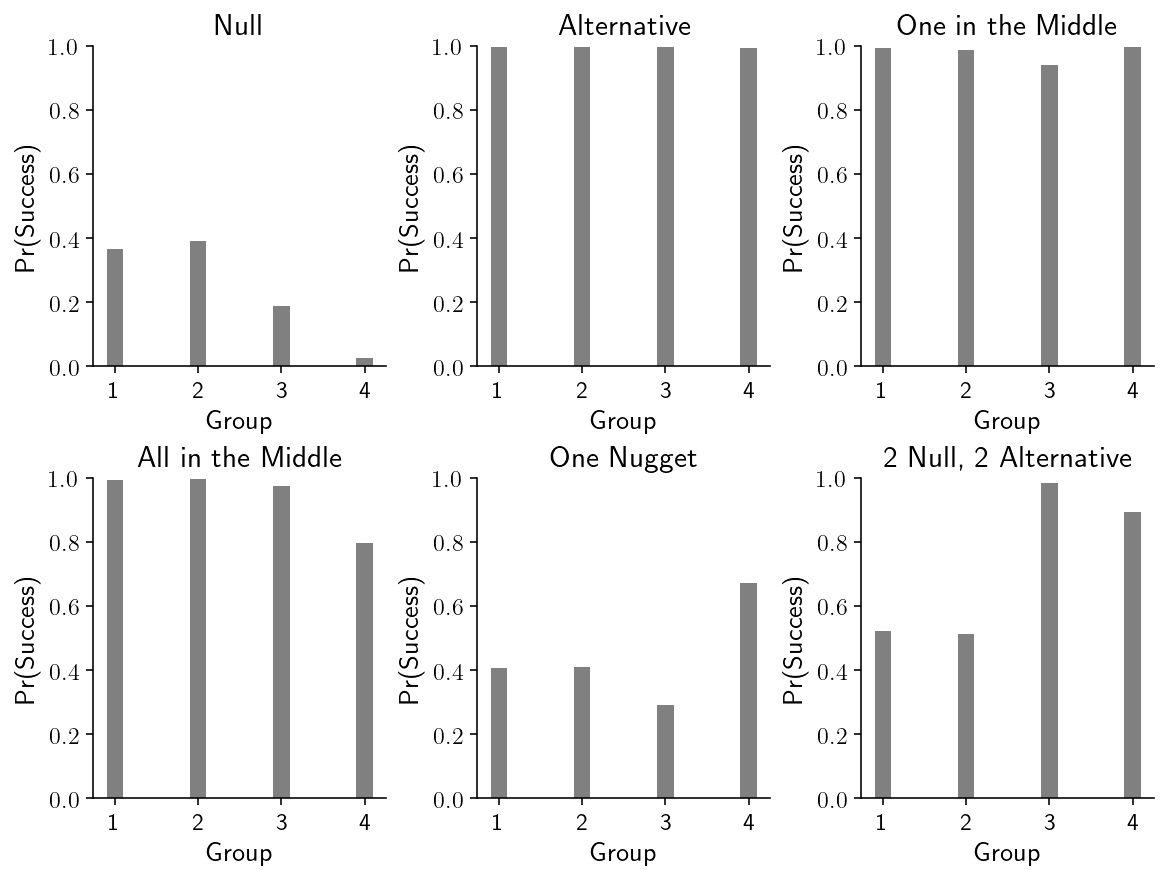

In [11]:
plt.figure(figsize=(8, 6), constrained_layout=True)
for i, k in enumerate(results):
    success = results[k]["success"]
    n_sims = success.shape[0]
    success_rate = success.sum(axis=0) / n_sims
    plt.subplot(2, 3, 1 + i)
    plt.title(k, fontweight="bold")
    plt.bar(
        np.arange(4),
        success_rate,
        0.2,
        color="gray",
    )

    plt.ylim([0, 1])
    plt.yticks(np.linspace(0, 1, 6))
    plt.ylabel("Pr(Success)")

    plt.xticks(np.arange(4), ["1", "2", "3", "4"])
    plt.xlabel("Group")

    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)

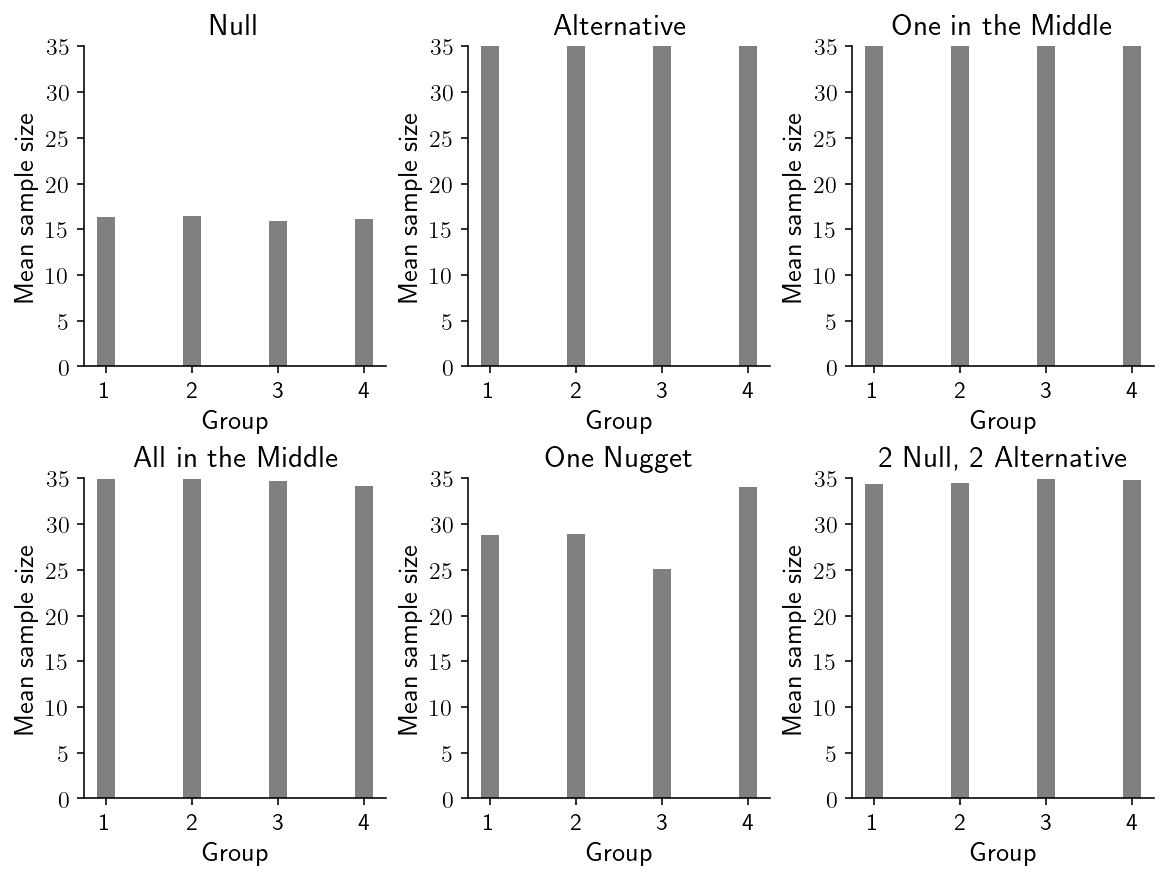

In [12]:
plt.figure(figsize=(8, 6), constrained_layout=True)
for i, k in enumerate(scenarios):
    sample_size = N_0 + results[k]["stopping_time"] * deltaN
    mean_sample_size = np.mean(sample_size, axis=0)

    plt.subplot(2, 3, 1 + i)
    plt.title(k, fontweight="bold")
    plt.bar(
        np.arange(4),
        mean_sample_size,
        0.2,
        color="gray",
    )

    plt.ylim([0, 35])
    plt.yticks(np.arange(0, 36, 5))
    plt.ylabel("Mean sample size")

    plt.xticks(np.arange(4), ["1", "2", "3", "4"])
    plt.xlabel("Group")

    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)
plt.show()